# Competition 2: Interpreting Cyber Intrusion Detection Models Using SHAP

# Part 1: Data Exploration and Model Training

### 1.1 Data Loading and Exploration
We load the cyber intrusion datasets for training and testing. New features like sload_dload_ratio, total_load, and dur_per_byte are created to better understand the data.

In [ ]:
# Importing libraries/modules
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap  # SHAP for model interpretability

In [ ]:
# Loading the datasets
train_data = pd.read_csv('UNSW_NB15_training-set.csv')
test_data = pd.read_csv('UNSW_NB15_testing-set.csv')

# Adding interaction features
train_data['sload_dload_ratio'] = train_data['sload'] / (train_data['dload'] + 1e-9)
test_data['sload_dload_ratio'] = test_data['sload'] / (test_data['dload'] + 1e-9)
train_data['total_load'] = train_data['sload'] + train_data['dload']
test_data['total_load'] = test_data['sload'] + test_data['dload']
train_data['dur_per_byte'] = train_data['dur'] / (train_data['sload'] + 1e-9)
test_data['dur_per_byte'] = test_data['dur'] / (test_data['sload'] + 1e-9)

### 1.2 Data Preprocessing
We select important features and prepare the data by encoding text-based columns into numbers. This makes sure that the data is ready for the machine learning model.

In [ ]:
# Selecting relevant features
X_train = train_data[['sload', 'ct_srv_src', 'ct_dst_ltm', 'dload', 'service', 'sload_dload_ratio', 'total_load', 'dur_per_byte']]
y_train = train_data['attack_cat']
X_test = test_data[['sload', 'ct_srv_src', 'ct_dst_ltm', 'dload', 'service', 'sload_dload_ratio', 'total_load', 'dur_per_byte']]
y_test = test_data['attack_cat']

# Encoding categorical variables
X_train = pd.get_dummies(X_train, columns=['service'])
X_test = pd.get_dummies(X_test, columns=['service'])
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Label encoding for target feature 'attack_cat'
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### 1.3 Model Training
We balance the data, split it into training and validation sets, and train models using hyperparameter tuning. A stacking model combines the best results.

In [ ]:
# Apply SMOTE for oversampling the minority class
smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Apply RandomUnderSampler
sampling_strategy = {
    0: 2000,  # Class 'Analysis'
    1: 1746,  # Class 'Backdoor'
    2: 9000,  # Class 'DoS'
    3: 27000, # Class 'Exploits'
    4: 35000  # Class 'Normal'
}

undersample = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_resampled, y_resampled = undersample.fit_resample(X_resampled, y_resampled)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Ensure all features in X_train and X_test are numeric
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Define parameter grids for hyperparameter tuning
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV for XGBoost
xgb_search = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=42),
                                param_distributions=xgb_param_grid,
                                n_iter=10, scoring='f1_weighted',
                                random_state=42, cv=3, verbose=1)

# RandomizedSearchCV for RandomForest
rf_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_distributions=rf_param_grid,
                               n_iter=10, scoring='f1_weighted',
                               random_state=42, cv=3, verbose=1)

# Fit both XGBoost and RandomForest with hyperparameter tuning
xgb_search.fit(X_train, y_train)
rf_search.fit(X_train, y_train)

# Get the best models
best_xgb_model = xgb_search.best_estimator_
best_rf_model = rf_search.best_estimator_

# Stacking classifier with the best models
stacked_model = StackingClassifier(
    estimators=[
        ('xgb', best_xgb_model),
        ('rf', best_rf_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42)
)

stacked_model.fit(X_train, y_train)

# Get the predicted probabilities
y_pred_prob = stacked_model.predict_proba(X_test)

# Combine predictions for all classes using majority vote
y_pred_adjusted = np.argmax(y_pred_prob, axis=1)

# Printing the classification report
print(classification_report(y_test, y_pred_adjusted, target_names=label_encoder.classes_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

    Analysis       0.06      0.01      0.01      2000
    Backdoor       0.08      0.04      0.05      1746
         DoS       0.37      0.23      0.28     12264
    Exploits       0.70      0.80      0.74     33393
      Normal       0.93      0.98      0.95     56000

    accuracy                           0.80    105403
   macro avg       0.43      0.41      0.41    105403
weighted avg       0.76      0.80      0.78    105403



# Part 2: Model Interpretability with SHAP

### 2.1 Setting Up SHAP
We set up SHAP to explain the XGBoost model's predictions.

In [ ]:
# SHAP Analysis for the XGBoost Model
print("Performing SHAP analysis for the XGBoost model...")

# Initialize SHAP explainer
xgb_explainer = shap.TreeExplainer(best_xgb_model)

Performing SHAP analysis for the XGBoost model...


### 2.2 Variable Importance with the Summary Plot
We calculate SHAP values and create a summary plot to show which features are most important for the model's predictions.


Generating Global SHAP Summary Plot...


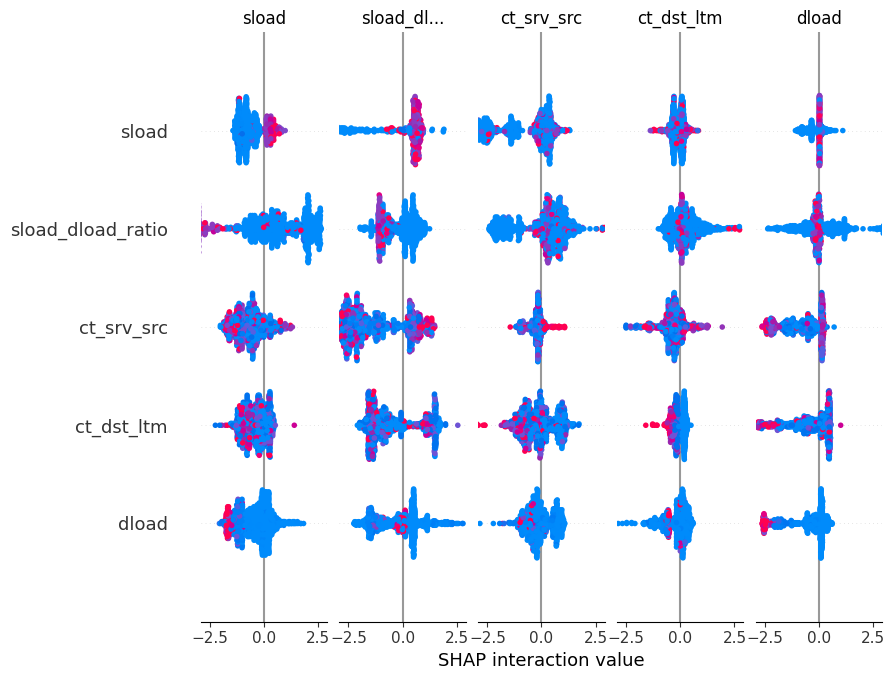

In [ ]:
# Perform SHAP on a subset of test data to save time
X_test_sample = X_test.sample(n=1000, random_state=42)  # Limiting to 1,000 samples
xgb_shap_values = xgb_explainer.shap_values(X_test_sample)

# Global SHAP Summary Plot
print("Generating Global SHAP Summary Plot...")
shap.summary_plot(xgb_shap_values, X_test_sample, feature_names=X_test_sample.columns)

### 2.3 Summary Plot of a Specific Target
We focus on a specific attack type to analyze its SHAP values and generate a summary plot to understand its feature importance.

Generating SHAP Summary Plot for the specific target: Backdoor...


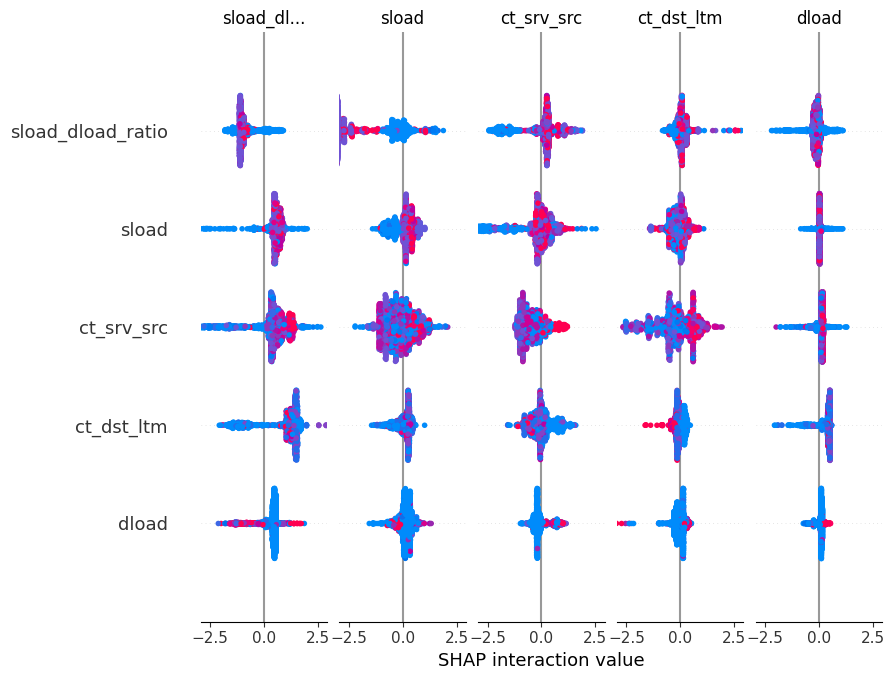

In [ ]:
# Filter test data for the specific target (e.g., 'Backdoor')
specific_attack_class = 'Backdoor'  # Replace with 'Analysis' or another class
specific_attack_label = list(label_encoder.classes_).index(specific_attack_class)
X_test_specific = X_test[y_test == specific_attack_label]

# Generate SHAP Summary Plot for the Specific Target
print(f"Generating SHAP Summary Plot for the specific target: {specific_attack_class}...")

# SHAP values for the selected class
specific_shap_values = xgb_explainer.shap_values(X_test_specific)

# If SHAP values are a list (multi-class case), select the appropriate class index
if isinstance(specific_shap_values, list):
    specific_shap_values_class = specific_shap_values[specific_attack_label]
else:
    specific_shap_values_class = specific_shap_values

# Generate the summary plot for the specific target class
shap.summary_plot(specific_shap_values_class, X_test_specific, feature_names=X_test_specific.columns)

# Multi-class SHAP case: Select first class for analysis
xgb_shap_values_class = np.array(xgb_shap_values)[..., 0]  # Select SHAP values for the first class (e.g., 'Analysis')

# Determine the most important feature
most_important_feature_index = np.argmax(np.abs(xgb_shap_values_class).mean(axis=0))
most_important_feature = X_test_sample.columns[most_important_feature_index]

### 2.4 Dependence Plot
We create a dependence plot to see how the most important feature affects the model's predictions.

Generating SHAP Dependence Plot for Feature: sload_dload_ratio


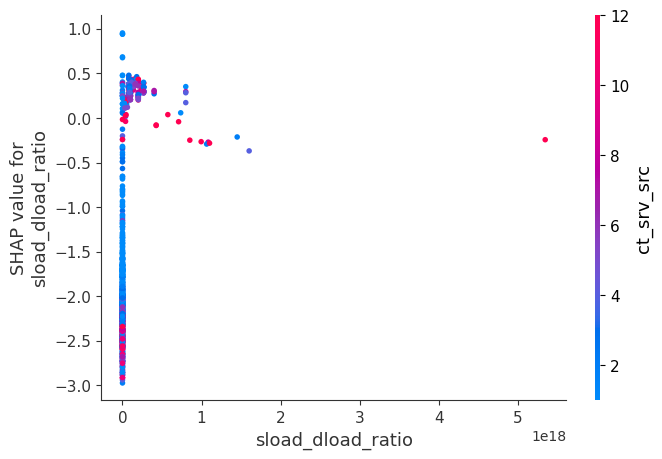

In [ ]:
# Dependence Plot
print(f"Generating SHAP Dependence Plot for Feature: {most_important_feature}")
shap.dependence_plot(most_important_feature, xgb_shap_values_class, X_test_sample)

# Part 3: Building Trust and Ensuring Fairness

### 3.1 Discussion on Transparency and Fairness
In AI-driven decision, transparency it is very important. This is especially true in cybersecurity to make sure users understand how predictions are made and can trust the system.

SHAP helps by explaining the impact of each feature on the model's decisions , making the process clear. This builds trust in AI systems by showing fairness and potential biases.

### 3.2 Recommendations
To improve the model, focusing on balancing the dataset by using techniques like data augmentation or oversampling for under-represented attacks. Using SHAP results to address biases to identify features causing unfair predictions. Also retraining the model with updated data to ensure fairness and accuracy.